In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
from xgboost import plot_importance
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Prepara o dataset ###

In [2]:
RANDOM_SEED=21

model = "random_forest"
src_type = "regular"

dir_results = f"../../data/results/{src_type}"
dir_figures = f"{dir_results}/figures/{model}"

if not os.path.exists(dir_figures):
    os.makedirs(dir_figures)

path_datasets = "../../data/datasets"
dataset = "Itaipu_POC_VAZAO_V2.csv"

## Número de Semanas Operativas Retroativas a serem utilizadas no Treinamento dos Algoritmos
n = 3

## Número da Semana Operativa Futura da Vazão a ser prevista pelos Modelos. min(f)=1
f = 3

In [3]:
df = pd.read_csv(f'{path_datasets}/{dataset}', index_col='time')
df

,bacia_prec_sum,vazao_itaipu
time,,
2000-06-30,2.539248e+05,217047.0
2000-07-31,2.773882e+05,229182.0
2000-08-31,4.983770e+05,229230.0
2000-09-30,8.890335e+05,407754.0
2000-10-31,4.884295e+05,267013.0
...,...,...
2021-08-31,9.598275e+04,123459.0
2021-09-30,1.757182e+05,114366.0
2021-10-31,1.389096e+06,259414.0


In [4]:
def dataset_constructor(df, n, f):
    for i in range(1, n): 
        df[f'bacia_prec_sum (time - {i})'] = df['bacia_prec_sum'].shift(i)
        df[f'vazao_itaipu (time - {i})'] = df['vazao_itaipu'].shift(i)

    df['bacia_prec_sum (time)'] = df['bacia_prec_sum']
    df['vazao_itaipu (time)'] = df['vazao_itaipu']

    for i in range(1,f+1):
        df[f'bacia_prec_sum (time + {i})'] = df['bacia_prec_sum'].shift(-i)
        
    df[f'vazao_itaipu (time + {f})'] = df['vazao_itaipu'].shift(-f)

    df = df.drop(columns=['bacia_prec_sum','vazao_itaipu'])
    df = df.dropna()
    
    return df

In [5]:
df = dataset_constructor(df, n, f)
df

,bacia_prec_sum (time - 1),vazao_itaipu (time - 1),bacia_prec_sum (time - 2),vazao_itaipu (time - 2),bacia_prec_sum (time),vazao_itaipu (time),bacia_prec_sum (time + 1),bacia_prec_sum (time + 2),bacia_prec_sum (time + 3),vazao_itaipu (time + 3)
time,,,,,,,,,,
2000-08-31,2.773882e+05,229182.0,253924.7500,217047.0,4.983770e+05,229230.0,8.890335e+05,4.884295e+05,1.056647e+06,284845.0
2000-09-30,4.983770e+05,229230.0,277388.2500,229182.0,8.890335e+05,407754.0,4.884295e+05,1.056647e+06,1.203936e+06,412779.0
2000-10-31,8.890335e+05,407754.0,498377.0000,229230.0,4.884295e+05,267013.0,1.056647e+06,1.203936e+06,1.009976e+06,427273.0
2000-11-30,4.884295e+05,267013.0,889033.5000,407754.0,1.056647e+06,284845.0,1.203936e+06,1.009976e+06,1.193691e+06,436733.0
2000-12-31,1.056647e+06,284845.0,488429.5000,267013.0,1.203936e+06,412779.0,1.009976e+06,1.193691e+06,8.709733e+05,399790.0
...,...,...,...,...,...,...,...,...,...,...
2021-05-31,1.177309e+05,192501.0,646968.1880,340038.0,2.147903e+05,154792.0,2.050504e+05,8.400806e+04,9.598275e+04,123459.0
2021-06-30,2.147903e+05,154792.0,117730.9375,192501.0,2.050504e+05,160122.0,8.400806e+04,9.598275e+04,1.757182e+05,114366.0
2021-07-31,2.050504e+05,160122.0,214790.3125,154792.0,8.400806e+04,138688.0,9.598275e+04,1.757182e+05,1.389096e+06,259414.0


In [6]:
y_original = df.iloc[:,-1:]
y_original

,vazao_itaipu (time + 3)
time,
2000-08-31,284845.0
2000-09-30,412779.0
2000-10-31,427273.0
2000-11-30,436733.0
2000-12-31,399790.0
...,...
2021-05-31,123459.0
2021-06-30,114366.0
2021-07-31,259414.0


In [7]:
def scaling_data(df):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Columns to scale for X and y
    columns_to_scale_X = df.columns[:-1]
    columns_to_scale_y = df.columns[-1]

    # Fit scalers on the selected columns and transform
    scaled_data_X = scaler_X.fit_transform(df[columns_to_scale_X])
    scaled_data_y = scaler_y.fit_transform(df[[columns_to_scale_y]])

    # Create DataFrame with scaled data
    scaled_X = pd.DataFrame(scaled_data_X, columns=columns_to_scale_X)
    scaled_y = pd.DataFrame(scaled_data_y, columns=[columns_to_scale_y])

    # Concatenate scaled columns to the original DataFrame
    new_df = pd.concat([pd.DataFrame(df.index), scaled_X, scaled_y], axis=1)
    new_df.set_index('time', inplace=True)

    return new_df, scaler_y

In [8]:
df, scaler_y = scaling_data(df)
df

,bacia_prec_sum (time - 1),vazao_itaipu (time - 1),bacia_prec_sum (time - 2),vazao_itaipu (time - 2),bacia_prec_sum (time),vazao_itaipu (time),bacia_prec_sum (time + 1),bacia_prec_sum (time + 2),bacia_prec_sum (time + 3),vazao_itaipu (time + 3)
time,,,,,,,,,,
2000-08-31,0.141679,0.153759,0.129469,0.137150,0.256676,0.156682,0.459964,0.251500,0.547186,0.232545
2000-09-30,0.256676,0.153824,0.141679,0.153759,0.459964,0.400200,0.251500,0.547186,0.623832,0.407055
2000-10-31,0.459964,0.398168,0.256676,0.153824,0.251500,0.208221,0.547186,0.623832,0.522900,0.426826
2000-11-30,0.251500,0.205538,0.459964,0.398168,0.547186,0.232545,0.623832,0.522900,0.618501,0.439730
2000-12-31,0.547186,0.229944,0.251500,0.205538,0.623832,0.407055,0.522900,0.618501,0.450566,0.389337
...,...,...,...,...,...,...,...,...,...,...
2021-05-31,0.058597,0.103554,0.333999,0.305486,0.109104,0.055144,0.104036,0.041049,0.047280,0.012403
2021-06-30,0.109104,0.051942,0.058597,0.103554,0.104036,0.062414,0.041049,0.047280,0.088772,0.000000
2021-07-31,0.104036,0.059237,0.109104,0.051942,0.041049,0.033177,0.047280,0.088772,0.720184,0.197855


In [9]:
df_poc = df.copy()

## Fazendo uma divisão treino/teste nos dados de vazão e aplicando normalização das colunas

In [10]:
X_data = df_poc.iloc[:,:-1].astype('float64')#.iloc[3:-1,:-1]
y_data = df_poc.iloc[:,-1:].astype('float64')#.iloc[3:-1,-1:]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((203, 9), (51, 9), (203, 1), (51, 1))

## Treinamento

In [11]:
rf = RandomForestRegressor(
    criterion='squared_error',
    n_estimators=50,
    max_depth=12,
    min_samples_split=2,
    min_samples_leaf=4,
    bootstrap=True
)

rf.fit(X_train, y_train)

<ipython-input-11-f0005ada6415>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=12, min_samples_leaf=4, n_estimators=50)

## Retomamos a escala original dos dados

In [12]:
## _ stands for normalized data

y_pred_ = rf.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_.reshape(-1,1))

y_test_ = y_test
y_test = scaler_y.inverse_transform(y_test)

In [13]:
y_test

array([[274391.  ],
       [216039.  ],
       [288389.38],
       [214026.  ],
       [205285.  ],
       [319456.  ],
       [114366.  ],
       [253268.46],
       [335007.  ],
       [170665.  ],
       [309303.  ],
       [585931.32],
       [396141.24],
       [447605.02],
       [484424.  ],
       [154792.  ],
       [413544.  ],
       [268337.  ],
       [271728.  ],
       [212995.  ],
       [380658.  ],
       [337207.  ],
       [242644.  ],
       [264498.88],
       [256894.  ],
       [327206.84],
       [515068.  ],
       [305608.  ],
       [199741.  ],
       [218337.  ],
       [408919.  ],
       [350907.  ],
       [449802.78],
       [190672.  ],
       [436455.  ],
       [300199.  ],
       [252466.96],
       [138291.  ],
       [454792.83],
       [204050.  ],
       [847468.56],
       [352391.  ],
       [228656.29],
       [304510.  ],
       [333597.  ],
       [194329.  ],
       [390421.85],
       [170897.  ],
       [333937.54],
       [506478.  ],


In [14]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
corr = np.corrcoef(y_test.T, y_pred.T)[0, 1]

metrics_df = pd.DataFrame(
    columns=['MAE', 'MSE', 'RMSE', 'R2', 'Corr'],
    index=['Decision Tree']
)

metrics_df['MAE'] = mae
metrics_df['MSE'] = mse
metrics_df['RMSE'] = rmse
metrics_df['R2'] = r2
metrics_df['Corr'] = corr
metrics_df

,MAE,MSE,RMSE,R2,Corr
Decision Tree,50744.499916,4.453042e+09,66731.116016,0.73326,0.861927


In [15]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=X_data.index,
        y=y_original.values.ravel(), # vazão observada
        mode='lines',
        name='Vazão observada',
    )
)

fig.add_trace(
    go.Scatter(
        x=X_test.index,
        y=y_pred.ravel(), # vazão prevista
        mode='markers',
        name='Forecast',
    )
)

fig.update_layout(title=f'Predição - Itaipu')

fig.write_image(f"{dir_figures}/history_measured_vs_predicted_plot.png", width=1400, scale=1)

fig.show()

In [16]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=y_test.flatten(),
        y=y_pred.flatten(),
        mode='markers',
        marker=dict(color='blue', opacity=0.5, line=dict(color='black', width=1)),
        name='Measured vs Predicted'
    )
)


fig.add_trace(
    go.Scatter(
        x=[y_pred.min(), y_pred.max()],
        y=[y_pred.min(), y_pred.max()],
        mode='lines',
        line=dict(color='red', dash='dash'),
        name='Identity Line'
    )
)

fig.update_layout(
    title='Measured vs Predicted',
    xaxis=dict(title='y_true'),
    yaxis=dict(title='y_pred'),
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=0, r=0, b=0, t=40),
    showlegend=True
)

fig.write_image(f"{dir_figures}/scattered_measured_vs_predicted_plot.png")

fig.show()


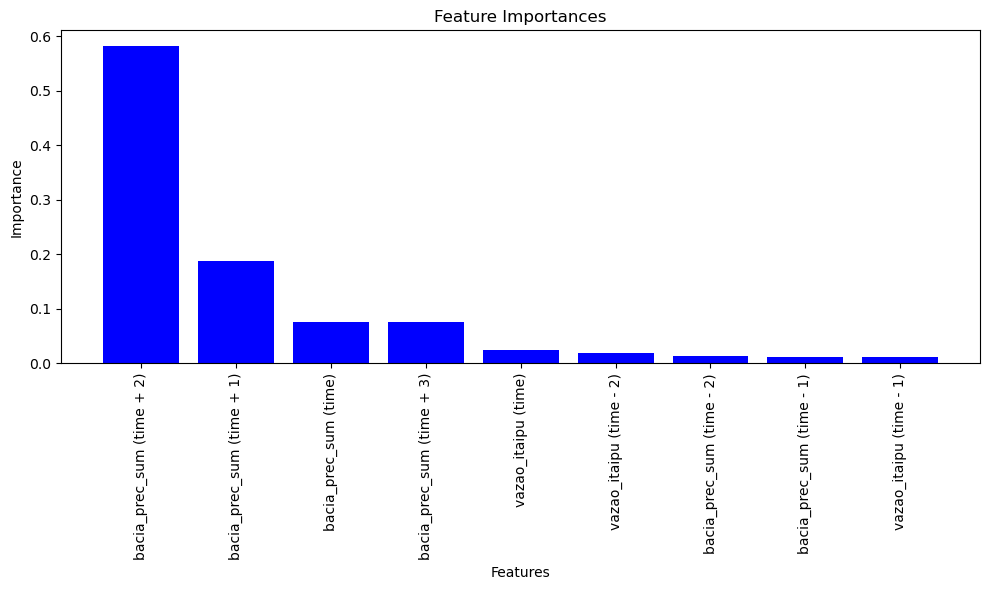

In [17]:
import matplotlib.pyplot as plt
import numpy as np

features = X_test.columns

# Get feature importances from the model
feature_importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Rearrange feature names based on feature importances
sorted_features = [features[i] for i in indices]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(features)), feature_importances[indices], color='b', align='center')
plt.xticks(range(len(features)), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()
